In [48]:
# install pytorch
!pip install torch torchvision torchaudio

In [49]:
## Setup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import anndata
import os

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

PyTorch version: 2.8.0
NumPy version: 2.0.2
Pandas version: 2.3.3


In [50]:
# Sanity check: working directory
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/tardis/Library/CloudStorage/GoogleDrive-natrdn@gmail.com/My Drive/Natália (Academic Folder)/Post_doc/Curso_MLinOmics/TODO/TODO/TODO/TODO/TODO


In [51]:
# Set working directory as instructed
!mkdir TODO
os.chdir("TODO")

In [52]:
# Load the data, normalization and filtering

import scanpy as sc

# Load the data
data = anndata.read_h5ad('/Users/tardis/Library/CloudStorage/GoogleDrive-natrdn@gmail.com/My Drive/Natália (Academic Folder)/Post_doc/Curso_MLinOmics/data/my_dataset_small.h5ad')

print("=" * 60)
print("DATA LOADING")
print("=" * 60)
print(f"Original data shape: {data.shape}")
print(f"Cells: {data.n_obs}, Genes: {data.n_vars}")

# Normalize (same as Day 1)
sc.pp.normalize_total(data, target_sum=1e6)
sc.pp.log1p(data)

# Filter genes (same as Day 1)
mean_expr = np.array(data.X.mean(axis=0)).flatten()
gene_filter = mean_expr > 0.1
data = data[:, gene_filter].copy()

print(f"\nAfter filtering:")
print(f"Data shape: {data.shape}")
print(f"Cells: {data.n_obs}, Genes: {data.n_vars}")


DATA LOADING
Original data shape: (2988, 33159)
Cells: 2988, Genes: 33159

After filtering:
Data shape: (2988, 13080)
Cells: 2988, Genes: 13080


In [53]:
# Subset to Astrocytes and Glioblasts
data = data[data.obs.author_cell_type.apply(lambda x: x in ["Astrocytes", "Glioblasts"])]

# Removing unexpressed genes
print("\Removing unexpressed genes for Astrocytes/Glioblasts subset...")
gene_sums = np.array(data.X.sum(axis=0)).flatten()
gene_filter = gene_sums > 0  # Remove completely unexpressed genes
data = data[:, gene_filter].copy()

print(f"Genes after re-filtering: {data.shape[1]}")
print("\n" + "=" * 60)
print("CELL TYPE FILTERING")
print("=" * 60)
print(f"Filtered data shape: {data.shape}")
print(f"\nCell type distribution:")
print(data.obs.author_cell_type.value_counts())

\Removing unexpressed genes for Astrocytes/Glioblasts subset...
Genes after re-filtering: 12995

CELL TYPE FILTERING
Filtered data shape: (440, 12995)

Cell type distribution:
author_cell_type
Astrocytes    264
Glioblasts    176
Name: count, dtype: int64


In [54]:
# Set up Pytorch Tensors (convertion of the input matrix to Pytorch Tensor)
# Obs: For the input, we need a dense numpy matrix
X = torch.Tensor(data.X.todense())

print("\n" + "=" * 60)
print("INPUT TENSOR (X)")
print("=" * 60)
print(f"X shape: {X.shape}")
print(f"X dtype: {X.dtype}")
print(f"\nFirst 5 cells, first 5 genes:")
print(X[:5, :5])


INPUT TENSOR (X)
X shape: torch.Size([440, 12995])
X dtype: torch.float32

First 5 cells, first 5 genes:
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 4.2953],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


In [55]:
# Convert output to Pytorch Tensor
# For the output, we need a dummy encoding (one hot encoding) of the label
# 1 for Astrocytes, 0 for Glioblasts
Y = torch.Tensor(np.array([[0 + (x == "Astrocytes") for x in data.obs.author_cell_type]])).transpose(0,1)

print("\n" + "=" * 60)
print("OUTPUT TENSOR (Y)")
print("=" * 60)
print(f"Y shape: {Y.shape}")
print(f"Y dtype: {Y.dtype}")
print(f"\nFirst 10 labels:")
print(Y[:10].squeeze())
print(f"\nLabel distribution:")
print(f"Astrocytes (1): {(Y == 1).sum().item()}")
print(f"Glioblasts (0): {(Y == 0).sum().item()}")


OUTPUT TENSOR (Y)
Y shape: torch.Size([440, 1])
Y dtype: torch.float32

First 10 labels:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Label distribution:
Astrocytes (1): 264
Glioblasts (0): 176


In [56]:
# Scale the data
def scale(x):
    """
    Scale features (genes) to have mean=0 and std=1.
    This is done by subtracting the mean and dividing by the SD.
    """
    m = x.mean(axis=0, keepdim=True)
    s = x.std(axis=0, unbiased=False, keepdim=True)
    x -= m
    x /= s
    return(x)

# Apply scaling
X = scale(X)

print("\n" + "=" * 60)
print("DATA SCALING")
print("=" * 60)
print(f"X shape after scaling: {X.shape}")
print(f"\nMean per gene (should be ~0):")
print(f"  First 5 genes: {X.mean(axis=0)[:5]}")
print(f"\nStd per gene (should be ~1):")
print(f"  First 5 genes: {X.std(axis=0, unbiased=False)[:5]}")
print(f"\nValue range:")
print(f"  Min: {X.min().item():.4f}")
print(f"  Max: {X.max().item():.4f}")


DATA SCALING
X shape after scaling: torch.Size([440, 12995])

Mean per gene (should be ~0):
  First 5 genes: tensor([ 1.3005e-08, -4.3349e-09, -2.1674e-09,  1.7340e-08, -1.0837e-09])

Std per gene (should be ~1):
  First 5 genes: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

Value range:
  Min: -13.3163
  Max: 20.9523


In [57]:
# I got 'nan' in the Value range of the scaling, so sanity check for that:
# 1) Check if X already has NaNs/Infs
print("NaNs in X before scaling:", torch.isnan(X).sum().item())
print("Infs in X before scaling:", torch.isinf(X).sum().item())

# 2) Check how many genes have zero std (AFTER your subsetting step!)
s = X.std(axis=0, unbiased=False, keepdim=True)
print("Genes with zero std:", (s == 0).sum().item(), "out of", s.numel())

NaNs in X before scaling: 0
Infs in X before scaling: 0
Genes with zero std: 0 out of 12995


In [58]:
# Design ML Model
class SimpleModel(nn.Module):
    """
    Simple binary classification model with:
    - One linear layer
    - Sigmoid activation
    """
    def __init__(self, input_dim):
        super(SimpleModel, self).__init__()
        # Instruction Task 1: Replace ??? with input_dim
        self.linear1 = nn.Linear(input_dim, 1)
        # Instruction Task 2: Add sigmoid transformation
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear1(x)
        # Task 2: Apply sigmoid transformation
        x = self.sigmoid(x)
        return x

print("\n" + "=" * 60)
print("MODEL DEFINITION")
print("=" * 60)
print("✓ SimpleModel class defined with:")
print("  - Linear layer: input_dim -> 1")
print("  - Sigmoid activation")


MODEL DEFINITION
✓ SimpleModel class defined with:
  - Linear layer: input_dim -> 1
  - Sigmoid activation


In [59]:
# Initialize the Model
# Get input dimension (number of genes)
input_dim = X.shape[1]

# Initialize model
model = SimpleModel(input_dim=input_dim)

print("\n" + "=" * 60)
print("MODEL INITIALIZATION")
print("=" * 60)
print(f"Input dimension: {input_dim}")
print(f"\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}") #Input dimension is 13,080 genes, and the model has one extra parameter because of a bias term from pytorch


MODEL INITIALIZATION
Input dimension: 12995

Model architecture:
SimpleModel(
  (linear1): Linear(in_features=12995, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 12,996


In [60]:
# Define Loss Function
criterion = nn.BCELoss()

print("\n" + "=" * 60)
print("LOSS FUNCTION")
print("=" * 60)
print(f"Criterion: {criterion}")
print("Note: BCEWithLogitsLoss combines sigmoid and BCE loss")


LOSS FUNCTION
Criterion: BCELoss()
Note: BCEWithLogitsLoss combines sigmoid and BCE loss


In [61]:
# Define optimizer
# Adam optimizer with learning rate 0.0001
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("\n" + "=" * 60)
print("OPTIMIZER")
print("=" * 60)
print(f"Optimizer: {optimizer}")
print(f"Learning rate: 0.0001")


OPTIMIZER
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Learning rate: 0.0001


In [62]:
# Look at the weights of the linear layer
print("\n" + "=" * 60)
print("INITIAL WEIGHTS")
print("=" * 60)
print(f"Linear layer weight shape: {model.linear1.weight.shape}")
print(f"Linear layer bias shape: {model.linear1.bias.shape}")
print(f"\nFirst 10 weight values:")
print(model.linear1.weight.data[0, :10])
print(f"\nBias value:")
print(model.linear1.bias.data)


INITIAL WEIGHTS
Linear layer weight shape: torch.Size([1, 12995])
Linear layer bias shape: torch.Size([1])

First 10 weight values:
tensor([-0.0034, -0.0083,  0.0052, -0.0006, -0.0041,  0.0065,  0.0064,  0.0043,
        -0.0009, -0.0016])

Bias value:
tensor([0.0034])


In [63]:
# Assess Perfomance
# Forward Pass
# Apply the model to the data (one forward pass)
outputs = model(X)

print("\n" + "=" * 60)
print("FORWARD PASS")
print("=" * 60)
print(f"Outputs shape: {outputs.shape}")
print(f"Outputs dtype: {outputs.dtype}")
print(f"\nFirst 10 output values (logits):")
print(outputs[:10].squeeze())
print(f"\nOutput range:")
print(f"  Min: {outputs.min().item():.4f}")
print(f"  Max: {outputs.max().item():.4f}")


FORWARD PASS
Outputs shape: torch.Size([440, 1])
Outputs dtype: torch.float32

First 10 output values (logits):
tensor([0.5884, 0.4010, 0.4303, 0.2917, 0.6126, 0.6647, 0.5650, 0.4053, 0.5121,
        0.6215], grad_fn=<SqueezeBackward0>)

Output range:
  Min: 0.1556
  Max: 0.8053


In [64]:
# Calculate loss compared to true labels
loss = criterion(outputs, Y)

print("\n" + "=" * 60)
print("LOSS CALCULATION")
print("=" * 60)
print(f"Loss: {loss.item():.4f}")


LOSS CALCULATION
Loss: 0.7512


In [65]:
# Step 1: Calculate output class probabilities
# Apply sigmoid to get probabilities from logits
probs = outputs

print("\n" + "=" * 60)
print("ACCURACY CALCULATION")
print("=" * 60)
print(f"Step 1 - Probabilities shape: {probs.shape}")
print(f"First 10 probabilities:")
print(probs[:10].squeeze())

# Step 2: Convert to boolean by testing whether value > 0.5
predictions_bool = probs > 0.5

print(f"\nStep 2 - Predictions (boolean):")
print(f"First 10: {predictions_bool[:10].squeeze()}")

# Step 3: Add 0 to convert boolean to numeric
predictions_numeric = predictions_bool + 0

print(f"\nStep 3 - Predictions (numeric):")
print(f"First 10: {predictions_numeric[:10].squeeze()}")

# Step 4: Test if equal to true labels
correct = (predictions_numeric == Y)

print(f"\nStep 4 - Correct predictions (boolean):")
print(f"First 10: {correct[:10].squeeze()}")

# Step 5: Sum the boolean results
num_correct = correct.sum()

print(f"\nStep 5 - Number correct: {num_correct.item()}")

# Step 6: Divide by number of samples
accuracy = num_correct / len(Y)

print(f"\nStep 6 - Accuracy: {accuracy.item():.4f} ({accuracy.item()*100:.2f}%)")


ACCURACY CALCULATION
Step 1 - Probabilities shape: torch.Size([440, 1])
First 10 probabilities:
tensor([0.5884, 0.4010, 0.4303, 0.2917, 0.6126, 0.6647, 0.5650, 0.4053, 0.5121,
        0.6215], grad_fn=<SqueezeBackward0>)

Step 2 - Predictions (boolean):
First 10: tensor([ True, False, False, False,  True,  True,  True, False,  True,  True])

Step 3 - Predictions (numeric):
First 10: tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 1])

Step 4 - Correct predictions (boolean):
First 10: tensor([ True, False, False, False,  True,  True,  True, False,  True,  True])

Step 5 - Number correct: 202

Step 6 - Accuracy: 0.4591 (45.91%)


In [66]:
# Single Training Step
print("\n" + "=" * 60)
print("TRAINING - SINGLE STEP")
print("=" * 60)

# Before training - save initial weights for comparison
initial_weights = model.linear1.weight.data.clone()
print(f"Initial weights (first 5): {initial_weights[0, :5]}")

# Step 1: Tell pytorch we will train
model.train()
print("\n✓ Step 1: model.train() called")
print(f"  Weights changed? {not torch.equal(model.linear1.weight.data, initial_weights)}")

# Step 2: Remove previous gradients
optimizer.zero_grad()
print("\n✓ Step 2: optimizer.zero_grad() called")
print(f"  Weights changed? {not torch.equal(model.linear1.weight.data, initial_weights)}")
print(f"  Gradients: {model.linear1.weight.grad}")

# Recalculate outputs and loss (needed for backward pass)
outputs = model(X)
loss = criterion(outputs, Y)

# Step 3: Backward pass to calculate gradients
loss.backward()
print("\n✓ Step 3: loss.backward() called")
print(f"  Weights changed? {not torch.equal(model.linear1.weight.data, initial_weights)}")
print(f"  Gradients exist? {model.linear1.weight.grad is not None}")
print(f"  First 5 gradients: {model.linear1.weight.grad[0, :5]}")

# Step 4: Optimize weights
optimizer.step()
print("\n✓ Step 4: optimizer.step() called") # The optimizer applied gradient descent using: w_new = w_old − lr × gradient
print(f"  Weights changed? {not torch.equal(model.linear1.weight.data, initial_weights)}")
print(f"  New weights (first 5): {model.linear1.weight.data[0, :5]}")

# Calculate accuracy after training step
model.eval()
with torch.no_grad():
    outputs_after = model(X)
    probs_after = torch.sigmoid(outputs_after)
    predictions_after = (probs_after > 0.5) + 0
    correct_after = (predictions_after == Y).sum()
    accuracy_after = correct_after / len(Y)

print(f"\n✓ Accuracy after 1 training step: {accuracy_after.item():.4f}")



TRAINING - SINGLE STEP
Initial weights (first 5): tensor([-0.0034, -0.0083,  0.0052, -0.0006, -0.0041])

✓ Step 1: model.train() called
  Weights changed? False

✓ Step 2: optimizer.zero_grad() called
  Weights changed? False
  Gradients: None

✓ Step 3: loss.backward() called
  Weights changed? False
  Gradients exist? True
  First 5 gradients: tensor([ 0.0103, -0.0214,  0.0416,  0.0387, -0.0109])

✓ Step 4: optimizer.step() called
  Weights changed? True
  New weights (first 5): tensor([-0.0035, -0.0082,  0.0051, -0.0007, -0.0040])

✓ Accuracy after 1 training step: 0.6000


In [67]:
# Training Loop (10 epochs)
print("\n" + "=" * 60)
print("TRAINING - MULTIPLE EPOCHS")
print("=" * 60)

# Reinitialize model for clean training from scratch
model = SimpleModel(input_dim=input_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
losses = []
accuracies = []

for epoch in range(num_epochs):
    # 1. Calculate output
    model.train()
    outputs = model(X)
    
    # 2. Calculate loss
    loss = criterion(outputs, Y)
    
    # 3. Backward pass
    optimizer.zero_grad()
    loss.backward()
    
    # 4. Optimize
    optimizer.step()
    
    # 5. Print loss
    losses.append(loss.item())
    
    # Calculate accuracy
    model.eval()
    with torch.no_grad():
        outputs_eval = model(X)
        probs = torch.sigmoid(outputs_eval)
        predictions = (probs > 0.5) + 0
        accuracy = ((predictions == Y).sum() / len(Y)).item()
        accuracies.append(accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {loss.item():.4f} | Accuracy: {accuracy:.4f}")

print("\n✓ Training complete!")


TRAINING - MULTIPLE EPOCHS
Epoch [1/10] | Loss: 0.6743 | Accuracy: 0.6000
Epoch [2/10] | Loss: 0.6625 | Accuracy: 0.6000
Epoch [3/10] | Loss: 0.6512 | Accuracy: 0.6000
Epoch [4/10] | Loss: 0.6405 | Accuracy: 0.6000
Epoch [5/10] | Loss: 0.6306 | Accuracy: 0.6000
Epoch [6/10] | Loss: 0.6213 | Accuracy: 0.6000
Epoch [7/10] | Loss: 0.6128 | Accuracy: 0.6000
Epoch [8/10] | Loss: 0.6048 | Accuracy: 0.6000
Epoch [9/10] | Loss: 0.5975 | Accuracy: 0.6000
Epoch [10/10] | Loss: 0.5906 | Accuracy: 0.6000

✓ Training complete!


In [68]:
# Inspeact Final Weights and Accuracy
print("\n" + "=" * 60)
print("FINAL RESULTS - SIMPLE MODEL")
print("=" * 60)

# Look at final weights
print(f"Final weights shape: {model.linear1.weight.shape}")
print(f"First 10 weight values:")
print(model.linear1.weight.data[0, :10])
print(f"\nFinal bias:")
print(model.linear1.bias.data)

# Final accuracy
print(f"\nFinal accuracy: {accuracies[-1]:.4f} ({accuracies[-1]*100:.2f}%)")
print(f"Initial loss: {losses[0]:.4f}")
print(f"Final loss: {losses[-1]:.4f}")
print(f"Loss reduction: {losses[0] - losses[-1]:.4f}")


FINAL RESULTS - SIMPLE MODEL
Final weights shape: torch.Size([1, 12995])
First 10 weight values:
tensor([ 0.0037,  0.0019,  0.0042,  0.0008, -0.0031, -0.0012,  0.0068,  0.0094,
         0.0035, -0.0021])

Final bias:
tensor([-0.0084])

Final accuracy: 0.6000 (60.00%)
Initial loss: 0.6743
Final loss: 0.5906
Loss reduction: 0.0837


In [69]:
# More elegant model: Complex model with hidden layer
class ComplexModel(nn.Module):
    """
    More complex binary classification model with:
    Layer 1:
        - Linear layer 1 (from input nodes to 50 hidden nodes)
        - Sigmoid layer 1
    Layer 2:
        - Linear layer 2 (from 50 hidden nodes to 1 output node)
        - Sigmoid layer 2
    """
    def __init__(self, input_dim):
        super(ComplexModel, self).__init__()
        # Layer 1
        self.linear1 = nn.Linear(input_dim, 50)
        self.sigmoid1 = nn.Sigmoid()
        
        # Layer 2
        self.linear2 = nn.Linear(50, 1)
        self.sigmoid2 = nn.Sigmoid()
        
    def forward(self, x):
        # Layer 1: Linear + Sigmoid
        x = self.linear1(x)
        x = self.sigmoid1(x)
        
        # Layer 2: Linear + Sigmoid
        x = self.linear2(x)
        x = self.sigmoid2(x)
        
        return x

print("\n" + "=" * 60)
print("COMPLEX MODEL DEFINITION")
print("=" * 60)
print("✓ ComplexModel class defined with:")
print("  - Layer 1: Linear(input_dim -> 50) + Sigmoid")
print("  - Layer 2: Linear(50 -> 1) + Sigmoid")


COMPLEX MODEL DEFINITION
✓ ComplexModel class defined with:
  - Layer 1: Linear(input_dim -> 50) + Sigmoid
  - Layer 2: Linear(50 -> 1) + Sigmoid


In [70]:
# Initialize and Train Complex Model
# Initialize complex model
complex_model = ComplexModel(input_dim=input_dim)

print("\n" + "=" * 60)
print("COMPLEX MODEL INITIALIZATION")
print("=" * 60)
print(complex_model)

# Count parameters
complex_params = sum(p.numel() for p in complex_model.parameters())
simple_params = sum(p.numel() for p in model.parameters())
print(f"\nComplex model parameters: {complex_params:,}")
print(f"Simple model parameters: {simple_params:,}")
print(f"Increase: {complex_params - simple_params:,} parameters")

# Note: With sigmoid in model, we should use BCELoss not BCEWithLogitsLoss
complex_criterion = nn.BCELoss()
complex_optimizer = optim.Adam(complex_model.parameters(), lr=0.0001)

print(f"\nLoss function: BCELoss (since sigmoid is in the model)")
print(f"Optimizer: Adam with lr=0.0001")


COMPLEX MODEL INITIALIZATION
ComplexModel(
  (linear1): Linear(in_features=12995, out_features=50, bias=True)
  (sigmoid1): Sigmoid()
  (linear2): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid2): Sigmoid()
)

Complex model parameters: 649,851
Simple model parameters: 12,996
Increase: 636,855 parameters

Loss function: BCELoss (since sigmoid is in the model)
Optimizer: Adam with lr=0.0001


In [71]:
#Train complex model (10 epochs)
print("\n" + "=" * 60)
print("TRAINING - COMPLEX MODEL")
print("=" * 60)

num_epochs = 10
complex_losses = []
complex_accuracies = []

for epoch in range(num_epochs):
    # 1. Calculate output
    complex_model.train()
    outputs = complex_model(X)
    
    # 2. Calculate loss
    loss = complex_criterion(outputs, Y)
    
    # 3. Backward pass
    complex_optimizer.zero_grad()
    loss.backward()
    
    # 4. Optimize
    complex_optimizer.step()
    
    # 5. Track metrics
    complex_losses.append(loss.item())
    
    # Calculate accuracy
    complex_model.eval()
    with torch.no_grad():
        outputs_eval = complex_model(X)
        predictions = (outputs_eval > 0.5) + 0
        accuracy = ((predictions == Y).sum() / len(Y)).item()
        complex_accuracies.append(accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {loss.item():.4f} | Accuracy: {accuracy:.4f}")

print("\n✓ Complex model training complete!")


TRAINING - COMPLEX MODEL
Epoch [1/10] | Loss: 0.6988 | Accuracy: 0.7386
Epoch [2/10] | Loss: 0.6600 | Accuracy: 0.8023
Epoch [3/10] | Loss: 0.6249 | Accuracy: 0.8568
Epoch [4/10] | Loss: 0.5935 | Accuracy: 0.8750
Epoch [5/10] | Loss: 0.5653 | Accuracy: 0.9000
Epoch [6/10] | Loss: 0.5397 | Accuracy: 0.9045
Epoch [7/10] | Loss: 0.5165 | Accuracy: 0.9091
Epoch [8/10] | Loss: 0.4950 | Accuracy: 0.9136
Epoch [9/10] | Loss: 0.4752 | Accuracy: 0.9295
Epoch [10/10] | Loss: 0.4569 | Accuracy: 0.9386

✓ Complex model training complete!



MODEL COMPARISON
  Model  Parameters  Initial Loss  Final Loss  Initial Accuracy  Final Accuracy
 Simple       12996      0.674289    0.590580          0.600000        0.600000
Complex      649851      0.698788    0.456909          0.738636        0.938636


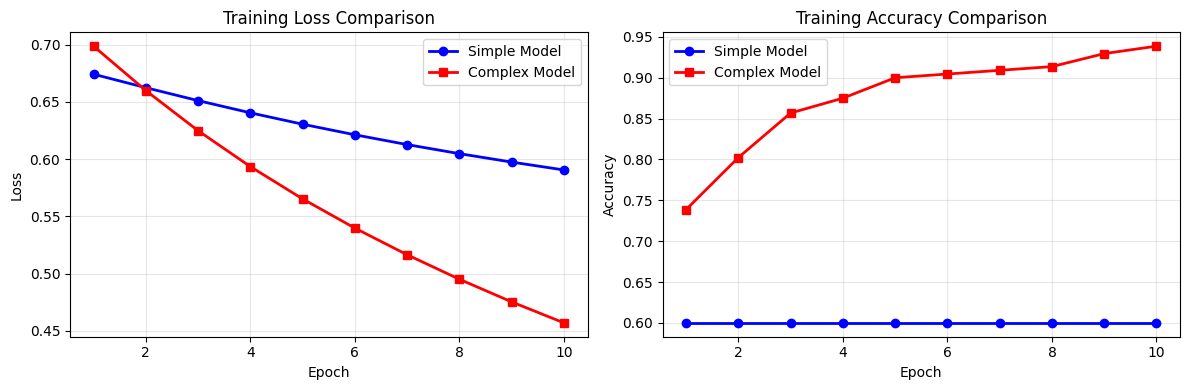


✓ Comparison plots saved as 'model_comparison.png'


In [72]:
# Comparison simple vs complex model
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Model': ['Simple', 'Complex'],
    'Parameters': [simple_params, complex_params],
    'Initial Loss': [losses[0], complex_losses[0]],
    'Final Loss': [losses[-1], complex_losses[-1]],
    'Initial Accuracy': [accuracies[0], complex_accuracies[0]],
    'Final Accuracy': [accuracies[-1], complex_accuracies[-1]]
})

print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss comparison
axes[0].plot(range(1, num_epochs+1), losses, 'b-o', label='Simple Model', linewidth=2)
axes[0].plot(range(1, num_epochs+1), complex_losses, 'r-s', label='Complex Model', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1].plot(range(1, num_epochs+1), accuracies, 'b-o', label='Simple Model', linewidth=2)
axes[1].plot(range(1, num_epochs+1), complex_accuracies, 'r-s', label='Complex Model', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison plots saved as 'model_comparison.png'")

In [73]:
# List of Layers (Bonus)
class OurNN_ListVersion(nn.Module):
    """
    Neural network using ModuleList for elegant layer management.
    """
    def __init__(self, input_dim):
        super(OurNN_ListVersion, self).__init__()
        layer_list = []
        
        # Layer 1: Linear(input_dim -> 50)
        layer_list.append(nn.Linear(input_dim, 50))
        # Activation 1: Sigmoid
        layer_list.append(nn.Sigmoid())
        # Layer 2: Linear(50 -> 1)
        layer_list.append(nn.Linear(50, 1))
        # Activation 2: Sigmoid
        layer_list.append(nn.Sigmoid())
        
        self.layers = nn.ModuleList(layer_list)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

print("\n" + "=" * 60)
print("LIST VERSION MODEL")
print("=" * 60)
print("✓ OurNN_ListVersion class defined")


LIST VERSION MODEL
✓ OurNN_ListVersion class defined


In [74]:
# Train List Version Model
# Initialize list version model
list_model = OurNN_ListVersion(input_dim=input_dim)

print("\n" + "=" * 60)
print("LIST VERSION MODEL INITIALIZATION")
print("=" * 60)
print(list_model)

# Verify same architecture as complex model
list_params = sum(p.numel() for p in list_model.parameters())
print(f"\nList model parameters: {list_params:,}")
print(f"Complex model parameters: {complex_params:,}")
print(f"Same architecture: {list_params == complex_params}")

# Train
list_criterion = nn.BCELoss()
list_optimizer = optim.Adam(list_model.parameters(), lr=0.0001)

print("\n" + "=" * 60)
print("TRAINING - LIST VERSION MODEL")
print("=" * 60)

num_epochs = 10
list_losses = []
list_accuracies = []

for epoch in range(num_epochs):
    # Training
    list_model.train()
    outputs = list_model(X)
    loss = list_criterion(outputs, Y)
    
    list_optimizer.zero_grad()
    loss.backward()
    list_optimizer.step()
    
    list_losses.append(loss.item())
    
    # Evaluation
    list_model.eval()
    with torch.no_grad():
        outputs_eval = list_model(X)
        predictions = (outputs_eval > 0.5) + 0
        accuracy = ((predictions == Y).sum() / len(Y)).item()
        list_accuracies.append(accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {loss.item():.4f} | Accuracy: {accuracy:.4f}")

print("\n✓ List version training complete!")
print(f"Final accuracy: {list_accuracies[-1]:.4f}")


LIST VERSION MODEL INITIALIZATION
OurNN_ListVersion(
  (layers): ModuleList(
    (0): Linear(in_features=12995, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

List model parameters: 649,851
Complex model parameters: 649,851
Same architecture: True

TRAINING - LIST VERSION MODEL
Epoch [1/10] | Loss: 0.6803 | Accuracy: 0.7568
Epoch [2/10] | Loss: 0.6351 | Accuracy: 0.8591
Epoch [3/10] | Loss: 0.5948 | Accuracy: 0.8818
Epoch [4/10] | Loss: 0.5591 | Accuracy: 0.9023
Epoch [5/10] | Loss: 0.5274 | Accuracy: 0.9227
Epoch [6/10] | Loss: 0.4988 | Accuracy: 0.9386
Epoch [7/10] | Loss: 0.4729 | Accuracy: 0.9477
Epoch [8/10] | Loss: 0.4492 | Accuracy: 0.9523
Epoch [9/10] | Loss: 0.4275 | Accuracy: 0.9568
Epoch [10/10] | Loss: 0.4076 | Accuracy: 0.9545

✓ List version training complete!
Final accuracy: 0.9545


In [75]:
# Exercises
# Describe dimensions, types, and value ranges for the following objects
print("\n" + "=" * 60)
print("EXERCISE 2.1: Object Descriptions")
print("=" * 60)

# 1. AnnData object after filtering
print("\n1. AnnData object 'data' after filtering genes and cells:")
print(f"   Type: {type(data)}")
print(f"   Dimensions: {data.shape} (cells × genes)")
print(f"   Number of cells: {data.n_obs}")
print(f"   Number of genes: {data.n_vars}")
print(f"   Data matrix type: {type(data.X)}")
print(f"   Data matrix shape: {data.X.shape}")
if hasattr(data.X, 'toarray'):
    dense_data = data.X.toarray()
    print(f"   Value range: [{dense_data.min():.4f}, {dense_data.max():.4f}]")
else:
    print(f"   Value range: [{data.X.min():.4f}, {data.X.max():.4f}]")

# 2. Input X
print("\n2. Input tensor 'X':")
print(f"   Type: {type(X)}")
print(f"   Shape: {X.shape} (method: X.shape)")
print(f"   Length: {len(X)} (function: len(X)) - number of samples")
print(f"   Dtype: {X.dtype}")
print(f"   Value range: [{X.min().item():.4f}, {X.max().item():.4f}]")
print(f"   Mean: {X.mean().item():.4f}")
print(f"   Std: {X.std().item():.4f}")

# 3. True output Y
print("\n3. True output tensor 'Y':")
print(f"   Type: {type(Y)}")
print(f"   Shape: {Y.shape}")
print(f"   Length: {len(Y)}")
print(f"   Dtype: {Y.dtype}")
print(f"   Value range: [{Y.min().item():.4f}, {Y.max().item():.4f}]")
print(f"   Unique values: {torch.unique(Y).tolist()}")
print(f"   Class distribution: 0={( Y== 0).sum().item()}, 1={(Y == 1).sum().item()}")

# 4. Predicted output
model.eval()
with torch.no_grad():
    outputs = model(X)
    
print("\n4. Predicted output 'outputs':")
print(f"   Type: {type(outputs)}")
print(f"   Shape: {outputs.shape}")
print(f"   Length: {len(outputs)}")
print(f"   Dtype: {outputs.dtype}")
print(f"   Value range (after sigmoid): [{outputs.min().item():.4f}, {outputs.max().item():.4f}]")
print(f"   Note: Simple model has sigmoid, so outputs are probabilities [0,1]")

# 5. Weights within model
print("\n5. Weights within the model object:")
print(f"   Type: {type(model)}")
print(f"   Linear layer weight type: {type(model.linear1.weight)}")
print(f"   Linear layer weight shape: {model.linear1.weight.shape}")
print(f"   Linear layer weight data type: {type(model.linear1.weight.data)}")
print(f"   Weight value range: [{model.linear1.weight.data.min().item():.4f}, {model.linear1.weight.data.max().item():.4f}]")
print(f"   Bias type: {type(model.linear1.bias)}")
print(f"   Bias shape: {model.linear1.bias.shape}")
print(f"   Bias value: {model.linear1.bias.data.item():.4f}")


EXERCISE 2.1: Object Descriptions

1. AnnData object 'data' after filtering genes and cells:
   Type: <class 'anndata._core.anndata.AnnData'>
   Dimensions: (440, 12995) (cells × genes)
   Number of cells: 440
   Number of genes: 12995
   Data matrix type: <class 'scipy.sparse._csr.csr_matrix'>
   Data matrix shape: (440, 12995)
   Value range: [0.0000, 12.0194]

2. Input tensor 'X':
   Type: <class 'torch.Tensor'>
   Shape: torch.Size([440, 12995]) (method: X.shape)
   Length: 440 (function: len(X)) - number of samples
   Dtype: torch.float32
   Value range: [-13.3163, 20.9523]
   Mean: 0.0000
   Std: 1.0000

3. True output tensor 'Y':
   Type: <class 'torch.Tensor'>
   Shape: torch.Size([440, 1])
   Length: 440
   Dtype: torch.float32
   Value range: [0.0000, 1.0000]
   Unique values: [0.0, 1.0]
   Class distribution: 0=176, 1=264

4. Predicted output 'outputs':
   Type: <class 'torch.Tensor'>
   Shape: torch.Size([440, 1])
   Length: 440
   Dtype: torch.float32
   Value range (afte

In [ ]:
# When Were Weights Changed? optimizer.step! 
# The optimizer applied gradient descent using: w_new = w_old − lr × gradient

In [77]:
# Was Learning Successful?
# Simpler model:
# First epoch = 45.91% (initial) 
#   ↓ [big jump in epoch 1]
# Last epoch = 60.00% ━━━━━━━━━━━━━ [plateaus for epochs 2-10]
# Complex model:
# first epoch = 73.86% (initial)
#   ↓ [steady improvement]
# last epoch = 93.86% (final)
# So both models learned, however the simpler model learned from the untrained weight for the first epoch and not much after. Different from the complex model.